In [129]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
import pickle

# Loding Arima data prepared as part of cleaning process

In [130]:
def loadData(fileName):
    dir=os.path.dirname(os.path.abspath("__file__"))
    # dir = os.path.dirname(__file__)
    # print("abs---",dir)
    filename = dir+'\\data\\' + fileName;
    # print("filename--",filename)
    return pd.read_csv(filename, low_memory=False,encoding='latin-1') 
ts_data = loadData('arima_df.csv')
# ts_data=ts_data.set_index('SCH_DEP_DATE')
print(len(ts_data))
ts_data.head()


1035


,SCH_DEP_DATE,cargo_diff
0,2019-01-01,-165779.94
1,2019-01-02,-311445.45
2,2019-01-03,714169.25
3,2019-01-04,272153.76
4,2019-01-05,834375.70


# SARIMAX Modeling

# Calculate RMSE, MAE score

In [131]:
def get_scores(data):
    model_scores = {}
    lag=18
    nan_count=data.isna().sum().sum()
    data = data.replace(np.nan, 0)
    rmse = np.sqrt(mean_squared_error(data.cargo_diff[-lag:], data.forecast[-lag:]))
    mae = mean_absolute_error(data.cargo_diff[-lag:], data.forecast[-lag:])
    r2 = r2_score(data.cargo_diff[-lag:], data.forecast[-lag:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))



# Sarimax Model

RMSE: 6110.980125742696
MAE: 4670.416666666667


901    1.873120e+05
902    6.738909e+05
903   -6.268407e+05
904   -1.325137e+06
905    4.456645e+05
           ...     
995   -1.860453e+06
996    7.985676e+05
997    6.690165e+05
998    1.733596e+05
999   -1.322826e+04
Name: forecast, Length: 99, dtype: float64

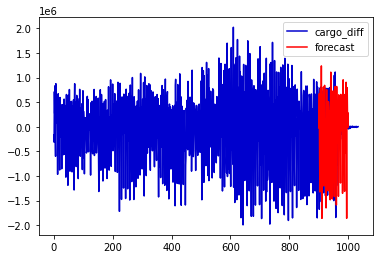

In [132]:
def sarimax_model(data):
    # data = data.reset_index()
    # Model
    sar = sm.tsa.statespace.SARIMAX(data.cargo_diff, order=(1,0,0), seasonal_order=(0,1,0,100), trend='c').fit()
       # Predictions
    length=len(data)
    start=900
    end=1000
    dynamic = 1
    # start, end, dynamic = 50, 100, 1
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['cargo_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)
predictions

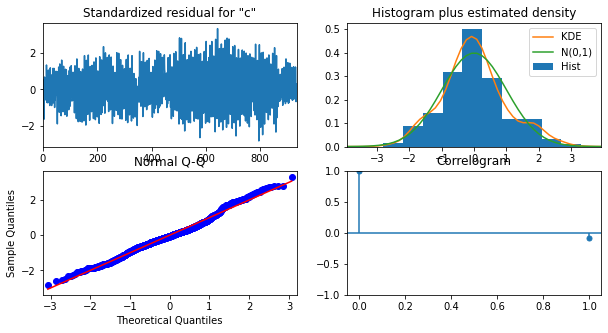

In [133]:
sar.plot_diagnostics(0,1,figsize=(10, 5));

# Plot Results

In [134]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    
    original_df = loadData('final_data.csv')
    # slct_df = original_df[(original_df.org == 'DWC') & (original_df.dst == 'ICN')]
    # original_df=original_df.dropna()
    # nan_count=original_df.isna().sum().sum()
    # print("NAN count--",nan_count)
    # ts_data = original_df.replace(np.nan, 0)
    # nan_count=original_df.isna().sum().sum()
    # print("NAN count--",nan_count)
    # original_df
    original_df.SCH_DEP_DATE = pd.to_datetime(original_df.SCH_DEP_DATE, format='%Y-%m-%d')
    original_df = original_df.groupby("SCH_DEP_DATE")['CHG_WT_BU_sum'].sum()
    original_df.SCH_DEP_DATE = pd.to_datetime(original_df.SCH_DEP_DATE)

    #create dataframe that shows the predicted sales
    result_list = []
    pred_len=len(prediction_df)
    cargo_dates = list(original_df[-pred_len:].SCH_DEP_DATE)
    act_cargo = list(original_df[-pred_len:].CHG_WT_BU_sum)
    # display(act_cargo)
    print(len(prediction_df))
    print(len(act_cargo))
    for index in range(0,len(prediction_df)-1):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_cargo[index])
        result_dict['SCH_DEP_DATE'] = cargo_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df


In [135]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.SCH_DEP_DATE, original_df.CHG_WT_BU_sum, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.SCH_DEP_DATE, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Cargo",
           title = f"{model_name} Cargo Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [136]:
# display(predictions)
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

99
99


KeyError: 0